In [2]:
import sys
sys.path.append('../../')
from fit.datamodules.super_res import MNIST_SResFITDM, CelebA_SResFITDM
from fit.utils import convert2DFT, pol2cart
from fit.utils.tomo_utils import get_polar_rfft_coords_2D
from fit.transformers_fit.PositionalEncoding2D import PositionalEncoding2D

from matplotlib import pyplot as plt

import torch

import numpy as np

/localscratch/miniforge3/envs/SSM_LS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# FIT for Super-Resolution

We train FIT for super-resolution auto-regressively. Therefor our data has to be ordered such that each prefix describes the whole image at reduced resolution. 

In [3]:
# dm = MNIST_SResFITDM(root_dir='./data/', batch_size=4)

dm = CelebA_SResFITDM(root_dir='./data/CelebA/', batch_size=4)

dm.prepare_data()
dm.setup()

Transformers require a positional encoding to make use of location information. We provide the Fourier coefficient locations as a positional encoding based on 2D polar coordinates.

Next to `r` and `phi` the coordinates of the Fourier coefficients we get `flatten_order`, which describes how the Fourier coefficients have to be arranged to be ordered from lowest to highest frequency. `fourier_rings` is the array on which `flatten_order` is computed.

In [8]:
r, phi, flatten_order, fourier_rings = get_polar_rfft_coords_2D(dm.gt_shape)

In [9]:
train_dl = dm.train_dataloader()

In [10]:
# x and y are normalized magnitude and angle of the Fourier coefficients
for x_fc, (amp_min, amp_max) in train_dl:
    break
    
# Here we sort the normalized amplitudes and phases from lowest to highest frequency.
x_fc = x_fc[:, flatten_order]

In [11]:
x_fc.shape

torch.Size([4, 2016, 2])

Here we can choose any prefix of the encoded sequence e.g. `k=100` the first 100 encoded Fourier coefficients.

In [15]:
k = 39
prefix = torch.zeros_like(x_fc)
prefix[...,0] += x_fc[...,0].min()
prefix[:,:k] = x_fc[:,:k]

Now we convert both sequences (the full and the prefix) back into Fourier spectra and then compute the inverse Fourier transform.

In [16]:
x_dft = convert2DFT(x_fc, amp_min, amp_max, flatten_order, img_shape=dm.gt_shape)
prefix_dft = convert2DFT(prefix, amp_min, amp_max, flatten_order, img_shape=dm.gt_shape)

In [21]:
from matplotlib.colors import LinearSegmentedColormap

In [22]:
colors = [(0.678, 0.847, 0.902), (0, 0, 0.8)]  # light blue to blue
n_bins = 20  # Discretizes the interpolation into bins
cmap_name = 'custom_blue'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

In [25]:
plt.figure(figsize=(100,100))
plt.subplot(2,2,1)
plt.imshow(torch.roll(torch.log(prefix_dft[0].abs()), dm.gt_shape//2, 0), cmap = cm)
plt.title('Prefix Fourier Spectrum')
plt.subplot(2,2,2)
plt.imshow(torch.roll(torch.log(x_dft[0].abs()), dm.gt_shape//2, 0))
plt.title('Full Fourier Spectrum')
plt.subplot(2,2,3)
plt.imshow(torch.fft.irfftn(prefix_dft[0], s=(dm.gt_shape,dm.gt_shape)), cmap='gray')
plt.title('Prefix');
plt.subplot(2,2,4)
plt.imshow(torch.fft.irfftn(x_dft[0], s=(dm.gt_shape,dm.gt_shape)), cmap='gray')
plt.title('Full Sequence');

# Positional Encoding

Since we work with transformers and want to utilize the location information of our data we have to provide it via positional encoding. Fourier spectra are best described by polar-coordinates, hence we use a polar-coordinate based positional encoding.

In [17]:
pos_enc = PositionalEncoding2D(8, (r, phi), flatten_order)

In [25]:
pos_enc.pe[0,:,0].shape

torch.Size([2016])

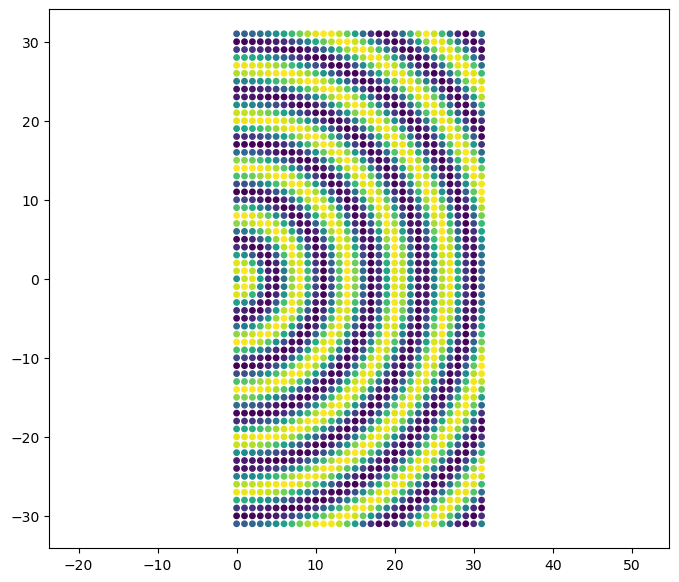

In [30]:
plt.figure(figsize=(8,7))
# plt.subplot(1,2,1)
plt.scatter(*pol2cart(r[flatten_order], phi[flatten_order]), c=pos_enc.pe[0,:,0], s=15)
plt.axis('equal');
# plt.title('Polar-Coordiante Positional Encoding\n Target-Radius');

# plt.subplot(1,2,2)
# plt.scatter(*pol2cart(r[flatten_order], phi[flatten_order]), c=pos_enc.pe[0,:,4], s=15)
# plt.axis('equal');
# plt.title('Polar-Coordiante Positional Encoding\n Target-Angle');

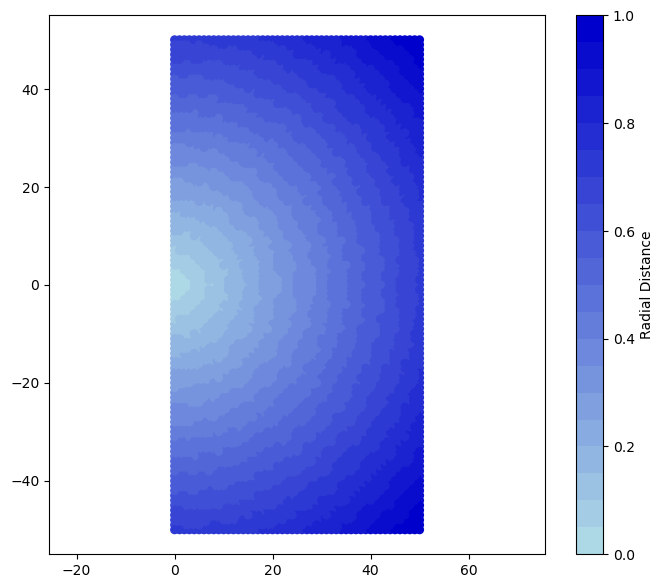

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
# Assuming r, phi, and flatten_order are defined
# r is the radial coordinate, phi is the angular coordinate, and flatten_order is the order for flattening

# Function to convert polar to cartesian coordinates
def pol2cart(r, phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return x, y

# Compute the cartesian coordinates
x, y = pol2cart(r[flatten_order], phi[flatten_order])

# Compute the radial distance for color mapping
radial_distance = np.sqrt(x**2 + y**2)

# Normalize the radial distance
norm = plt.Normalize(radial_distance.min(), radial_distance.max())

colors = [(0.678, 0.847, 0.902), (0, 0, 0.8)]  # light blue to blue
n_bins = 20  # Discretizes the interpolation into bins
cmap_name = 'custom_blue'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

plt.figure(figsize=(8, 7))
scatter = plt.scatter(x, y, c=norm(radial_distance), cmap=cm, s=30, marker='o')
plt.axis('equal')

# Add concentric circles with black borders
max_radius = radial_distance.max()
num_rings = 9  # Number of rings

# for i in range(1, 3):
#     circle = plt.Circle((0, 0), max_radius * i / num_rings, color='black', fill=False, linestyle='-', linewidth=1)
#     plt.gca().add_artist(circle)
    
# for i in range(6,8):
#     circle = plt.Circle((0, 0), max_radius * i / num_rings, color='black', fill=False, linestyle='-', linewidth=1)
#     plt.gca().add_artist(circle)

plt.colorbar(scatter, label='Radial Distance')
plt.show()
